# Learning Shapelets

## Reference

This refers to the following paper by Grabocka _et al._:
> Learning Time-Series Shapelets. 
> Josif Grabocka, Nicolas Schilling, Martin Wistuba, Lars Schmidt-Thieme
> http://www.ismll.uni-hildesheim.de/pub/pdfs/grabocka2014e-kdd.pdf

## Content

In this paper, authors suggest that one should rather learn time series that are likely to lead to good classification instead of finding them in the data, as was done by previous works.
The optimization strategy is a standard gradient descent over shapelets elements and logistic regression coefficients.
Experiments are conducted on the UCR datasets.



In [1]:
%matplotlib inline

import numpy
import os
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def load_dataset(ds_name, path="data/ucr"):
    directory = "%s/%s" % (path, ds_name)
    fname_train, fname_test = None, None
    for fname in os.listdir(directory):
        if fname.endswith("_TRAIN.txt"):
            fname_train = os.path.join(directory, fname)
        elif fname.endswith("_TEST.txt"):
            fname_test = os.path.join(directory, fname)
    data_train = numpy.loadtxt(fname_train)
    n, sz = data_train.shape
    x_train, y_train = data_train[:, 1:].reshape((n, sz - 1, 1)), data_train[:, 0]
    data_test = numpy.loadtxt(fname_test)
    n, sz = data_test.shape
    x_test, y_test = data_test[:, 1:].reshape((n, sz - 1, 1)), data_test[:, 0]
    return x_train, y_train, x_test, y_test

numpy.random.seed(0)
x_train, y_train, x_test, y_test = load_dataset("GunPoint", "../../TSC_dataset/data_out/")
print(y_train)

# 0/1 setup
y_train[y_train <= 1.5] = 0
y_train[y_train > 1.5] = 1
y_test[y_test <= 1.5] = 0
y_test[y_test > 1.5] = 1

print(x_train.shape, x_test.shape)

[ 2.  2.  1.  1.  2.  2.  2.  2.  2.  1.  1.  1.  1.  1.  2.  1.  2.  2.
  1.  2.  1.  1.  1.  2.  1.  2.  1.  1.  2.  1.  1.  2.  2.  1.  2.  1.
  2.  2.  2.  2.  2.  1.  1.  1.  2.  2.  1.  2.  1.  2.]
(50, 150, 1) (150, 150, 1)


Let us start by defining some basic functions that compute the gradient of the loss wrt shapelet coefficients, and all it needs to be computed:

In [2]:
def shapelet_transform_with_offset(ts_i, shapelets):
    L = ts_i.shape[0]
    dists = []
    for shp in shapelets:
        sz = shp.shape[0]
        dists.append(numpy.min([numpy.linalg.norm(ts_i[t:t+sz] - shp) ** 2 for t in range(L-sz+1)]) / sz)
    return numpy.array([1] + dists)

def predict(ts_i, shapelets, weights):
    return 1. / (1 + numpy.exp(- numpy.dot(weights, shapelet_transform_with_offset(ts_i, shapelets))))

def loss(time_series, classes, shapelets, weights, lambda_w):
    total_loss = 0.
    for ts_i, yi in zip(time_series, classes):
        s_yi_hat = predict(ts_i, shapelets, weights)
        total_loss += - yi * numpy.log(s_yi_hat) - (1. - yi) * numpy.log(1 - s_yi_hat)
    total_loss += lambda_w * numpy.linalg.norm(weights) ** 2
    return total_loss / time_series.shape[0]

def grad_Skl(ts_i, y_i, shapelets, weights):
    dL_dYi = - (y_i - predict(ts_i, shapelets, weights))
    n_shapelets = len(shapelets)
    L = ts_i.shape[0]
    dYi_dSkl = []
    for k in range(n_shapelets):
        sz = shapelets[k].shape[0]
        dYi_dMik = weights[k + 1]
        j = numpy.argmin([numpy.linalg.norm(ts_i[t:t+sz] - shapelets[k]) ** 2 for t in range(L-sz+1)])
        dMik_dSkl = shapelets[k] - ts_i[j:j+sz] # Limit when alpha -> -inf
        dYi_dSkl.append(dYi_dMik * dMik_dSkl / sz)
    return [dL_dYi * dYi_dSkl[k] for k in range(n_shapelets)]

def grad_Wk(ts_i, y_i, shapelets, weights, lambda_w, n_samples):
    n_shapelets = len(shapelets)
    gr = - 0.5 * (y_i - predict(ts_i, shapelets, weights)) * shapelet_transform_with_offset(ts_i, shapelets)
    gr += lambda_w * weights / n_samples
    return gr

In [3]:
def init_shapelets_kmeans(time_series, K, L, n_draw=10000):
    n_ts, ts_len, d = time_series.shape
    indices_ts = numpy.random.choice(n_ts, size=n_draw, replace=True)
    indices_time = numpy.random.choice(ts_len - L + 1, size=n_draw, replace=True)
    subseries = numpy.zeros((n_draw, L, d))
    for i in range(n_draw):
        subseries[i] = time_series[indices_ts[i], indices_time[i]:indices_time[i] + L]
    subseries = subseries.reshape((n_draw, L * d))
    return KMeans(n_clusters=K).fit(subseries).cluster_centers_.reshape((K, L, d))

n_shapelets = 20
sz = 60
lambda_w = 0.01
shapelets = init_shapelets_kmeans(x_train, n_shapelets, sz)
weights = numpy.random.randn(n_shapelets + 1)
print(loss(x_train, y_train, shapelets, weights, lambda_w))

0.669546841243


Let us know have a look at what the stochastic gradient descent looks like:

In [4]:
def update_shapelets_and_weights(ts_i, y_i, shapelets, weights, lambda_w, n_samples, eta):
    delta_Skl = grad_Skl(ts_i, y_i, shapelets, weights)
    delta_Wk = grad_Wk(ts_i, y_i, shapelets, weights, lambda_w, n_samples)
    
    weights -= eta * delta_Wk
    for k in range(len(shapelets)):
        shapelets[k] -= eta * delta_Skl[k]
    return shapelets, weights

eta = 0.01
for i in range(100001):  # 100k iterations
    idx = numpy.random.randint(x_train.shape[0])
    ts_i = x_train[idx]
    y_i = y_train[idx]
    shapelets, weights = update_shapelets_and_weights(ts_i, y_i, shapelets, weights, lambda_w, x_train.shape[0], eta)
    if i % 5000 == 0:
        print(i, loss(x_train, y_train, shapelets, weights, lambda_w=0.01))

0 0.667400036465
5000 0.419464315502
10000 0.366213747974
15000 0.338330176613
20000 0.320268533608
25000 0.307371445002
30000 0.296229372015
35000 0.286421815897
40000 0.277479563897
45000 0.269273702776
50000 0.261437985843
55000 0.25379915672
60000 0.247324209396
65000 0.239722816837
70000 0.232149858105
75000 0.225324722328
80000 0.219048344841
85000 0.211499523283
90000 0.20494045594
95000 0.199001013109
100000 0.192923639423


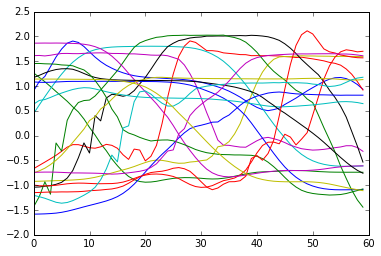

In [5]:
for shp in shapelets:
    plt.plot(numpy.arange(shp.shape[0]), shp)

Of course, this code is not optimized (some quantities are computed several time at each iteration), but it gives an idea of how LS works. Also, in this implementation, we do not use soft-min functions in order to make gradient formulas simpler to compute, but the adaptation should be straightforward.

In [6]:
n_correct = 0
for idx_test in range(x_test.shape[0]):
    yi_hat = predict(x_test[idx_test], shapelets, weights)
    if (yi_hat > .5 and y_test[idx_test] == 1) or (yi_hat <= .5 and y_test[idx_test] == 0):
        n_correct += 1
print(n_correct, x_test.shape[0])

138 150


## Adversarial time series

Now, let us generate adversarial samples that are very close to correctly classified time series but can still fool the system.
To do so, we perform gradient descent on time series elements.

In [7]:
def grad_Rij(ts_i, target_label, shapelets, weights):
    dL_dYi = - (target_label - predict(ts_i, shapelets, weights))
    n_shapelets = len(shapelets)
    L = ts_i.shape[0]
    dYi_dTij = numpy.zeros(ts_i.shape)
    for k in range(n_shapelets):
        sz = shapelets[k].shape[0]
        j_star = numpy.argmin([numpy.linalg.norm(ts_i[t:t+sz] - shapelets[k]) ** 2 for t in range(L-sz+1)])
        dYi_dTij[j_star:j_star+sz] += weights[k+1] * (ts_i[j_star:j_star+sz] - shapelets[k]) / sz
    return dL_dYi * dYi_dTij

idx_ts = 0
ts_i = x_train[idx_ts].copy()
y_true = y_train[idx_ts]
y_target = 1 - y_true

print(y_true, predict(ts_i, shapelets, weights))

eta = 0.001
lambda_res = .1
residual = numpy.zeros(ts_i.shape)
for niter in range(50001):
    residual -= eta * grad_Rij(ts_i, y_target, shapelets, weights)
    residual *= (1 - eta * lambda_res)
    ts_i = x_train[idx_ts] + residual
    if niter % 1000 == 0:
        print(niter, predict(ts_i, shapelets, weights), 
              numpy.linalg.norm(ts_i - x_train[idx_ts]) / numpy.linalg.norm(x_train[idx_ts]))
        if numpy.abs(y_target - predict(ts_i, shapelets, weights)) < 0.45:
            print("Stopped after %d iterations" % niter)
            break

1.0 0.673443480501
0 0.673228365516 4.70108645055e-05
1000 0.492672774725 0.037191759288
2000 0.384728674604 0.060058367398
Stopped after 2000 iterations


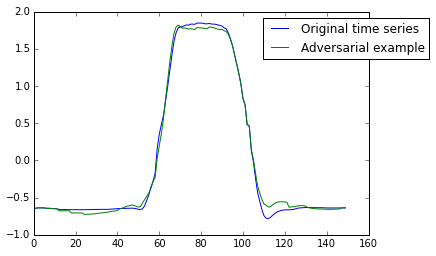

In [8]:
L = ts_i.shape[0]
plt.plot(numpy.arange(L), x_train[idx_ts], label="Original time series")
plt.plot(numpy.arange(L), ts_i, label="Adversarial example")
plt.legend(bbox_to_anchor=(1.2, 1))